In [15]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=31

In [16]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [17]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95,axis=0):
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m, se = np.mean(a,axis=axis), scipy.stats.sem(a,axis=axis)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

### Read data and dpca

In [18]:
samples={
    "o0_c0": 0,
    "o1_c1": 1,
    "o1_c5": 2,
    "o5_c5": 3,
    "o5_c1": 4,
}
samples={
    "o1_c1": 0,
    "o1_c5": 1,
    "o5_c5": 2,
    "o5_c1": 3,
}

In [100]:
save_fig=True
# Load data
area='PFC'
n_trials=10
n_test=1
time_before=500
start=-400
end_test = n_test*450+200
end=450+200+200+end_test
idx_start = time_before + start 
idx_end = time_before+end
T=end-start
T

1900

In [101]:
basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area
path = basepath + '/nksmt/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt.hs'
X_fr_raw = from_python_hdf5(path)[0]['pp']#
X_fr_raw.shape

(10, 1152, 4, 2, 1900)

In [102]:
fold_size = 160
k_folds = int(np.floor(X_fr_raw.shape[1]/fold_size))
rng = np.random.default_rng(seed=seed)
neurons_folds = rng.choice(X_fr_raw.shape[1], size=k_folds*fold_size, replace=False)
neurons_folds = neurons_folds.reshape(k_folds,-1)

In [103]:
neurons_folds.shape

(7, 160)

In [104]:
X_fr_raw.shape

(10, 1152, 4, 2, 1900)

In [105]:
X_fr = firing_rate.convolve_signal(arr=X_fr_raw,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)[:,:,:,:,200:1500+200]
X_fr.shape

(10, 1152, 4, 2, 1500)

In [106]:
# X_fr_test = X_fr[8:]
# X_fr=X_fr[:8]

In [107]:
#X_fr = X_fr/np.max(X_fr,axis=(0,2,3,4))[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]

In [108]:
N=X_fr.shape[1]
# trial-average data
X = np.mean(X_fr,0)
# center data
print(X.shape)

(1152, 4, 2, 1500)


In [109]:
dpca = dPCA.dPCA(labels='smt',join= {'st' : ['s','st'],'mt' : ['m','mt'],'smt': ['sm','smt']},regularizer=1.4757890559999992e-06,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
dpca.protect = ['t']
dpca.fit(X,X_fr)

In [110]:
round(dpca.regularizer,10)

1.4758e-06

In [111]:
X_test.shape

(161, 4, 2, 1500)

In [112]:
variances = dpca.get_variances(X)

In [113]:
variances['total_marg_var']

{'t': 2302387481.7962484,
 'st': 289389811.14135945,
 'mt': 219770955.53919294,
 'smt': 240916149.87186027}

In [114]:
variances.keys()

dict_keys(['cumulative_var', 'component_var', 'marg_var', 'total_marg_var', 'which_marg'])

In [115]:
marg_var_t = variances['marg_var']['t']
marg_var_st = variances['marg_var']['st']
marg_var_mt = variances['marg_var']['mt']
#marg_var_sm = variances['marg_var']['sm']
marg_var_smt = variances['marg_var']['smt']

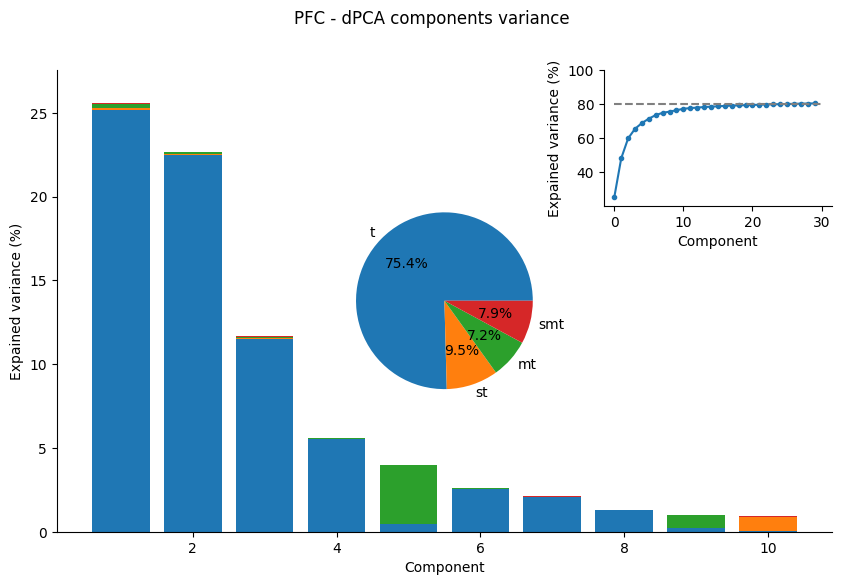

In [116]:
n_comp=10
t_var = np.array(marg_var_t[:n_comp])
st_var = np.array(marg_var_st[:n_comp])
mt_var = np.array(marg_var_mt[:n_comp])
#sm_var = np.array(marg_var_sm[:n_comp])
smt_var = np.array(marg_var_smt[:n_comp])

f,ax = plt.subplots(figsize=(10,6))
#ax.bar(range(n_comp),s_var, label='s')
ax.bar(np.arange(n_comp)+1,t_var, label='t')
ax.bar(np.arange(n_comp)+1,st_var, bottom= t_var, label='st')
ax.bar(np.arange(n_comp)+1,mt_var, bottom= (t_var+st_var), label='mt')
#ax.bar(np.arange(n_comp)+1,sm_var, bottom= (t_var+st_var+mt_var), label='sm')
ax.bar(np.arange(n_comp)+1,smt_var, bottom= (t_var+st_var+mt_var), label='smt')#+sm_var
ax.set(xlabel='Component', ylabel='Expained variance (%)')
#ax.legend()
ax.set_ylim(0,(t_var+st_var+mt_var+smt_var)[0]+2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# f,ax = plt.subplots(figsize=(3,3))
ax2 = plt.subplot2grid((4, 4), (1, 1),2,2)
_=ax2.pie([variances['total_marg_var']['t'],variances['total_marg_var']['st'],variances['total_marg_var']['mt'],variances['total_marg_var']['smt']],labels=['t','st','mt','smt'],autopct='%1.1f%%')
ax3 = plt.subplot2grid((3, 3), (0, 2))
if np.any(variances['cumulative_var'][:n_comp-4]>80):
    i_comp = n_comp
elif np.any(variances['cumulative_var']>80):
    i_comp = np.where(variances['cumulative_var']>80)[0][0] +4
else:
    i_comp = len(variances['cumulative_var'])

ax3.plot(variances['cumulative_var'][:i_comp],'.-')
ax3.hlines(80,0,i_comp,colors='grey',linestyles='--')
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.set_ylim(np.min(variances['cumulative_var'][:i_comp])-5,100)
ax3.set(xlabel='Component', ylabel='Expained variance (%)')
f.suptitle('%s - dPCA components variance'%(area.upper()))
if save_fig:
    path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' + 'variance.jpg'
    f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)

In [117]:
comp_plot = 3

# X_full = np.mean(X_fr,0)
# X = X_full.reshape((N,-1))
# X_cen = X - np.mean(X,1)[:,None]

Z =   dpca.transform(X)#X_cen.T@dpca.D_sorted #
which_marg = variances['which_marg']
marg_labels=np.unique(which_marg)
components =np.concatenate([np.where(which_marg==i)[0][:comp_plot] for i in marg_labels])
comp_in_z = np.concatenate([[i]*comp_plot for i in marg_labels])
#.T[components].reshape(np.concatenate((components.shape,X.shape[1:])))

In [118]:
# which_marg=variances['which_marg']
# components =np.concatenate([np.where(which_marg==i)[0][:comp_plot] for i in np.unique(which_marg)])

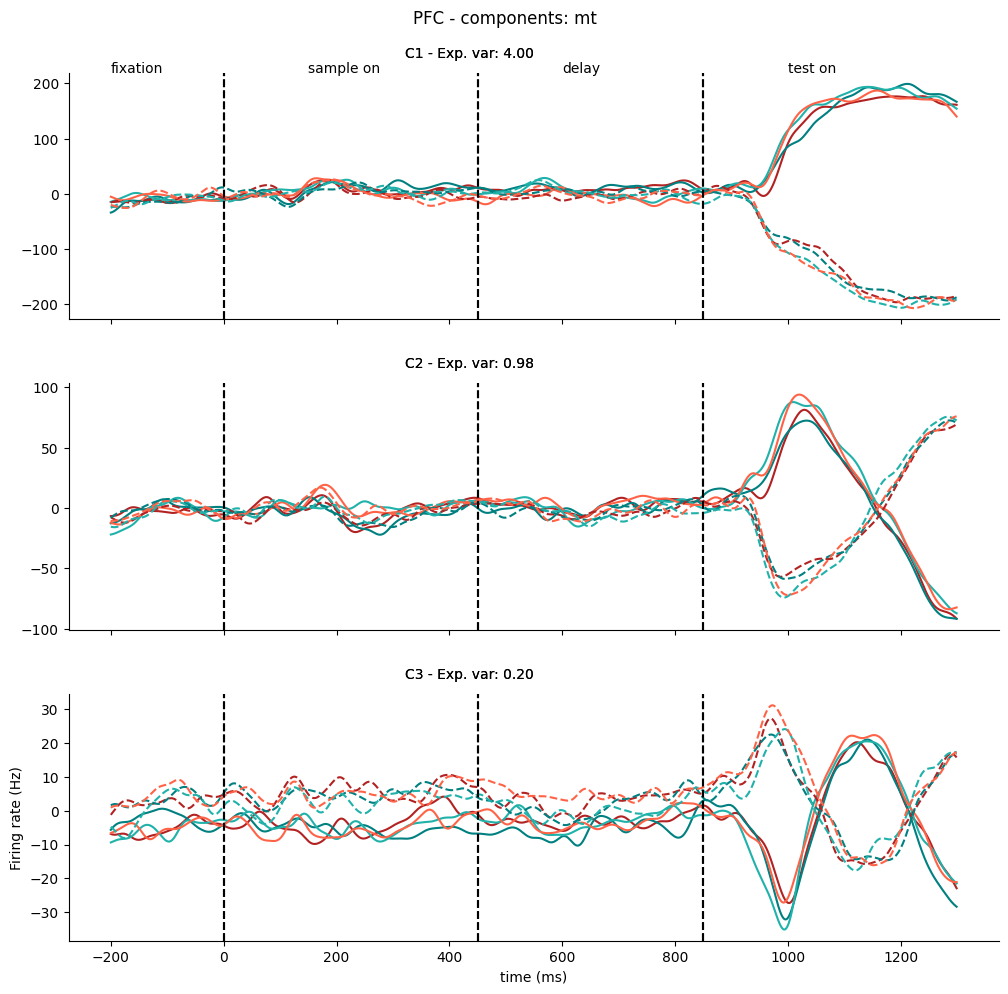

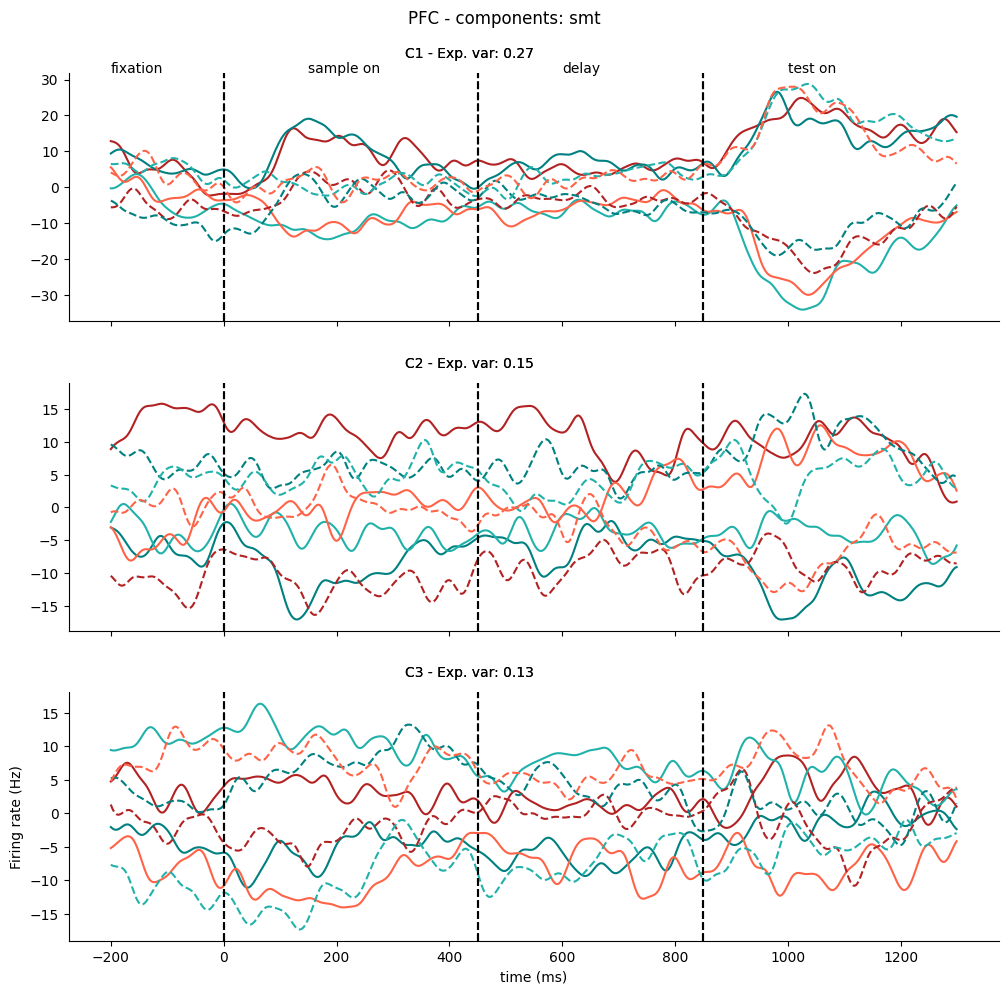

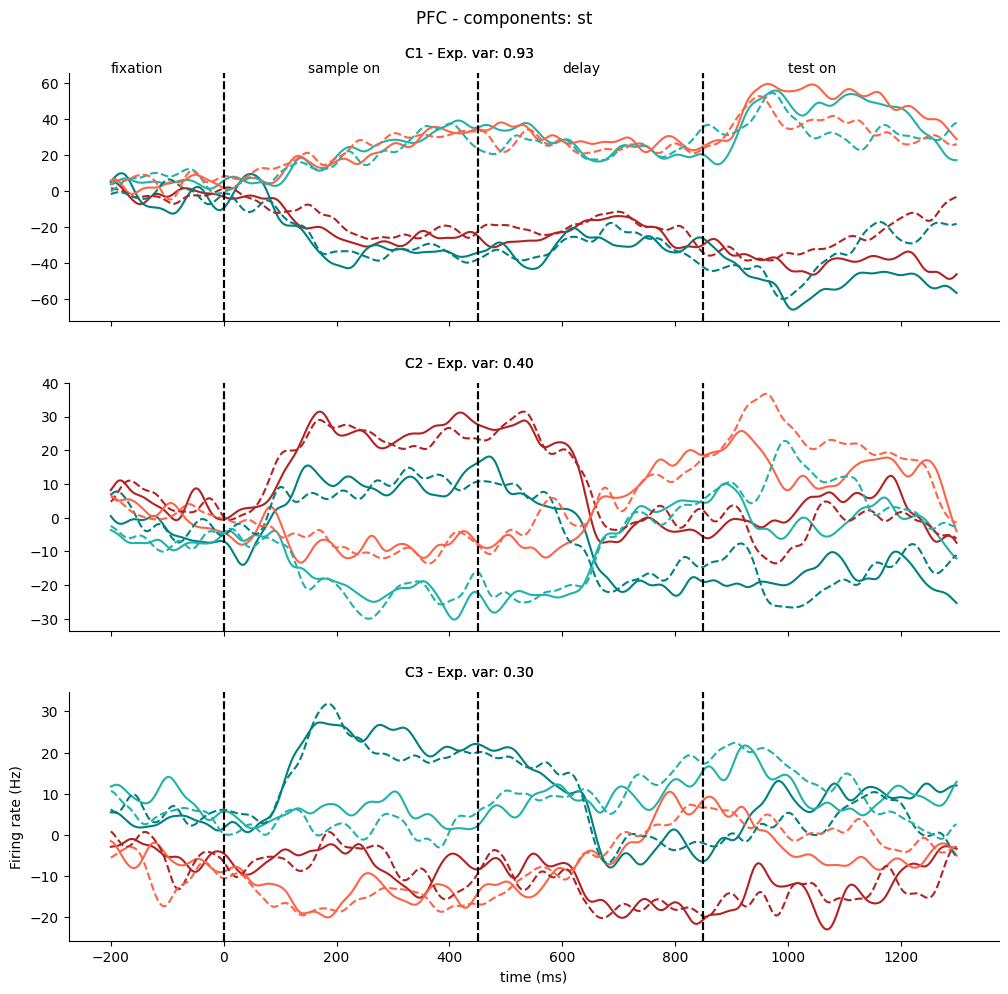

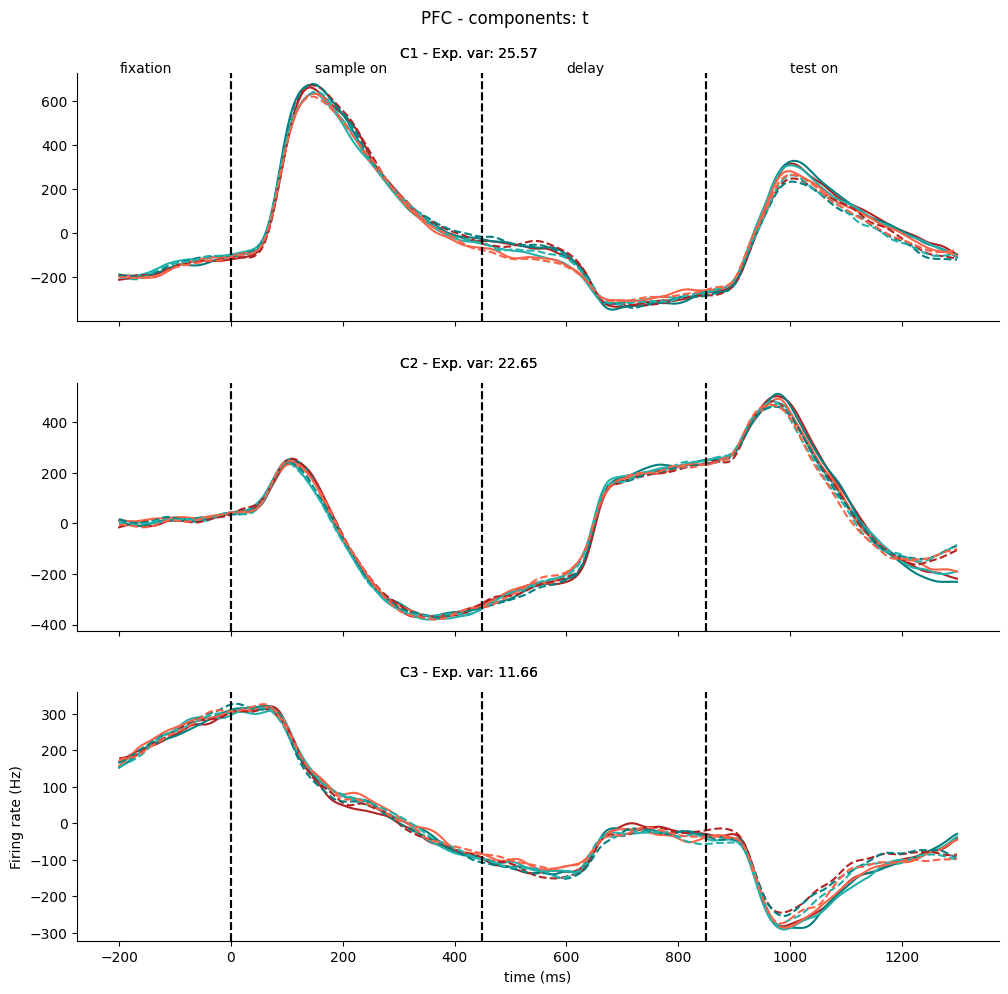

In [119]:
save_fig=False
time = np.arange(X.shape[-1]) - 200#np.arange(T-400)-200
n_plots,i_plot=0,0#
for i in range(len(comp_in_z)):
    
    i_comp = comp_in_z[i]
    if i_plot!=0 and i_plot < comp_plot:
        ax=ax_all[i_plot]
        i_plot+=1
    else:    
        f,ax_all=plt.subplots(3,1,figsize=(10,10),sharex=True)
        ax=ax_all[0]
        i_plot =1
    for i_m in range(2):
        lstyle = '-' if i_m == 0 else '--'
        for s in samples.keys():
            ax.plot(time,Z[i_comp][i_plot-1][samples[s]][i_m],color=task_constants.PALETTE_B1[s],linestyle=lstyle)
        max_v = np.max(Z[i_comp][i_plot-1][samples[s]])
        min_v = np.min(Z[i_comp][i_plot-1][samples[s]])
        ax.axvline(0,color='k',linestyle='--')
        ax.axvline(450,color='k',linestyle='--')
        ax.axvline(850,color='k',linestyle='--')
        ax.text(0.5,1.05,'C%d - Exp. var: %.2f'%(i_plot,variances['component_var'][i_comp][i_plot-1]),horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes)
        ax.set_title(' ',fontsize=40)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
    if i_plot == 1:
        ax.text(-200, ax.get_ylim()[1], 'fixation')
        ax.text(150, ax.get_ylim()[1], 'sample on')
        ax.text(600, ax.get_ylim()[1], 'delay')
        ax.text(1000, ax.get_ylim()[1], 'test on')
    if i_plot == 3:
        ax.set(xlabel='time (ms)', ylabel='Firing rate (Hz)')
    f.suptitle('%s - components: %s'%(area.upper(),i_comp))
    f.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    if save_fig:
        path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' +i_comp+ '_components.jpg'
        f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)

## Transform on single trials

In [120]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95,axis=0):
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m, se = np.mean(a,axis=axis), scipy.stats.sem(a,axis=axis)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [121]:
X_tr=np.transpose(X_fr,(1,0,2,3,4))
Z_tr_raw=dpca.transform(X_tr.reshape(X_tr.shape[0],-1))#X_fr)
Z_tr={}
for i_comp in Z_tr_raw.keys():
    Z_tr[i_comp]= np.transpose(Z_tr_raw[i_comp].reshape(-1,10, 4, 2, 1500),(1,0,2,3,4))

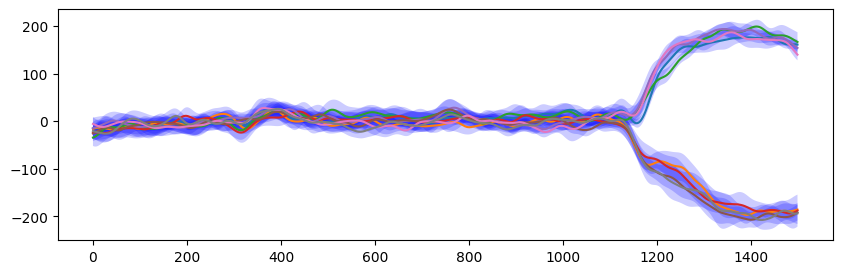

In [122]:
f,ax_all=plt.subplots(figsize=(10,3))
for i_s in range(4):
    for i_r in range(2):
        m, m_min, m_max = mean_confidence_interval(Z_tr['mt'][:,0,i_s,i_r], confidence=0.95)
        plt.plot(m)
        plt.fill_between(range(len(m_min)), m_min, m_max, facecolor='blue', alpha=0.2)

In [123]:
N=X_fr_test.shape[1]
# trial-average data
X_test = np.mean(X_fr_test,0)
# center data
print(X_test.shape)

NameError: name 'X_fr_test' is not defined

In [ ]:
comp_plot = 3

Z_full =   dpca.transform(X_test)#X_cen.T@dpca.D_sorted #
which_marg = variances['which_marg']
marg_labels=np.unique(which_marg)
components =np.concatenate([np.where(which_marg==i)[0][:comp_plot] for i in marg_labels])
comp_in_z = np.concatenate([[i]*comp_plot for i in marg_labels])
Z= Z_full#.T[components].reshape(np.concatenate((components.shape,X.shape[1:])))

ValueError: shapes (100,1152) and (161,12000) not aligned: 1152 (dim 1) != 161 (dim 0)

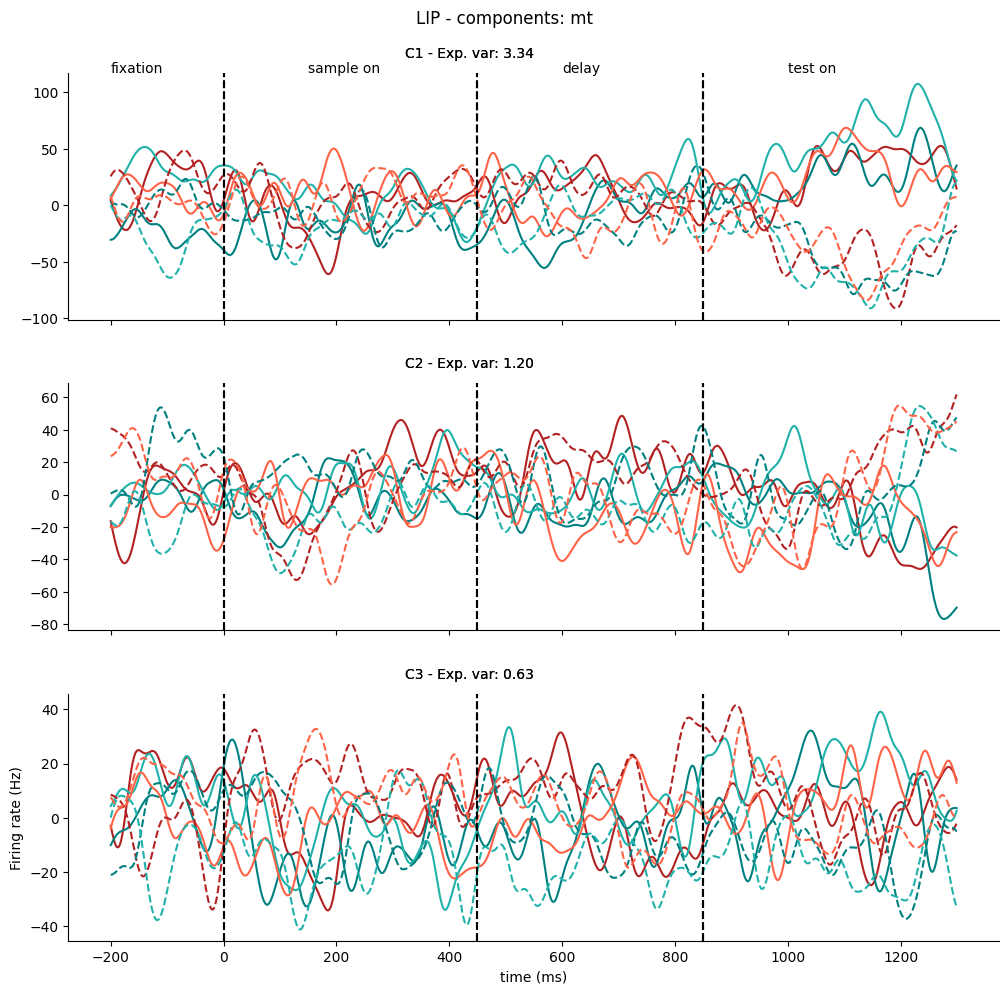

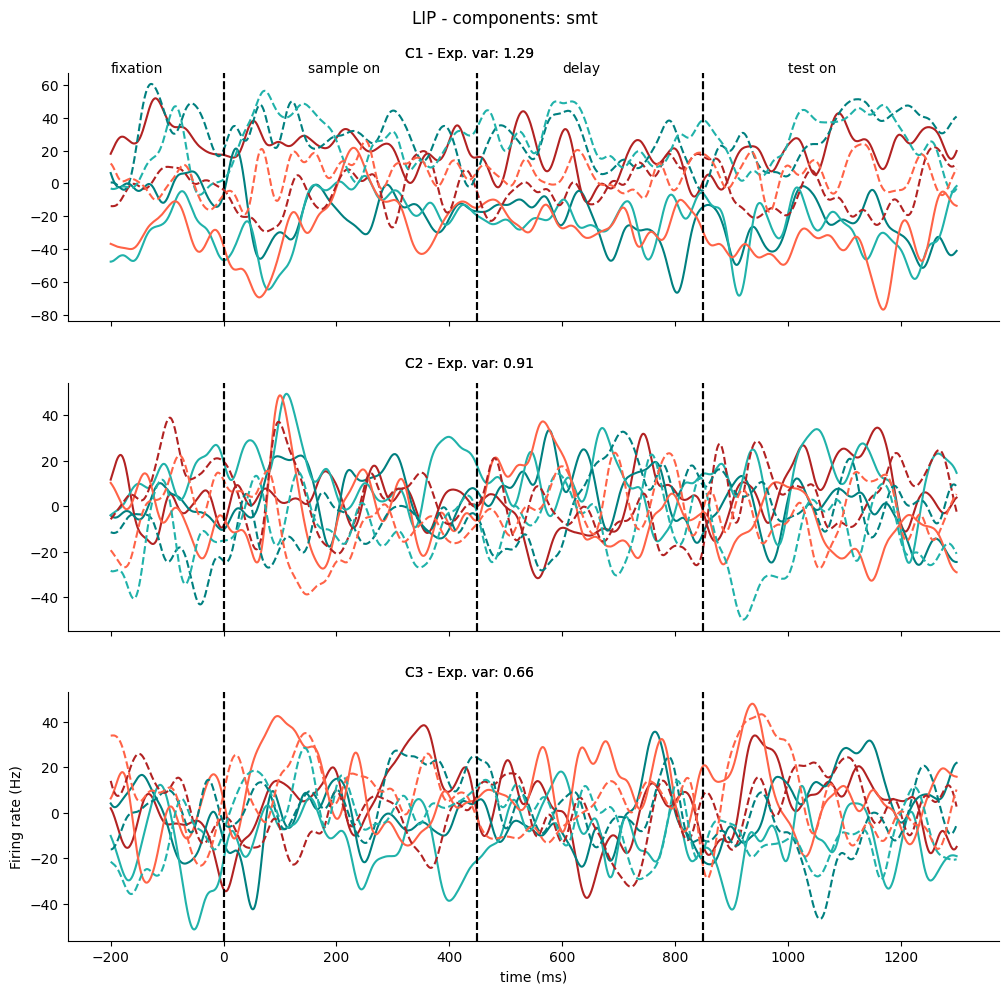

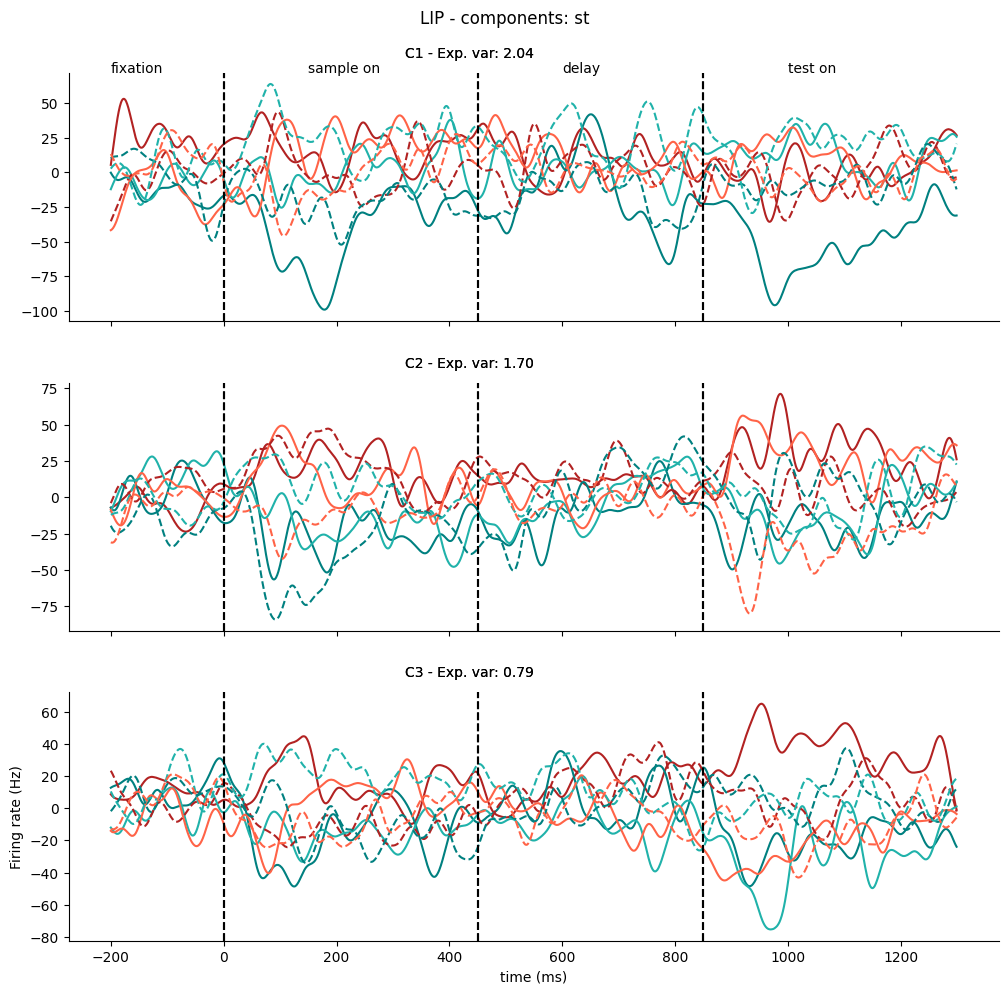

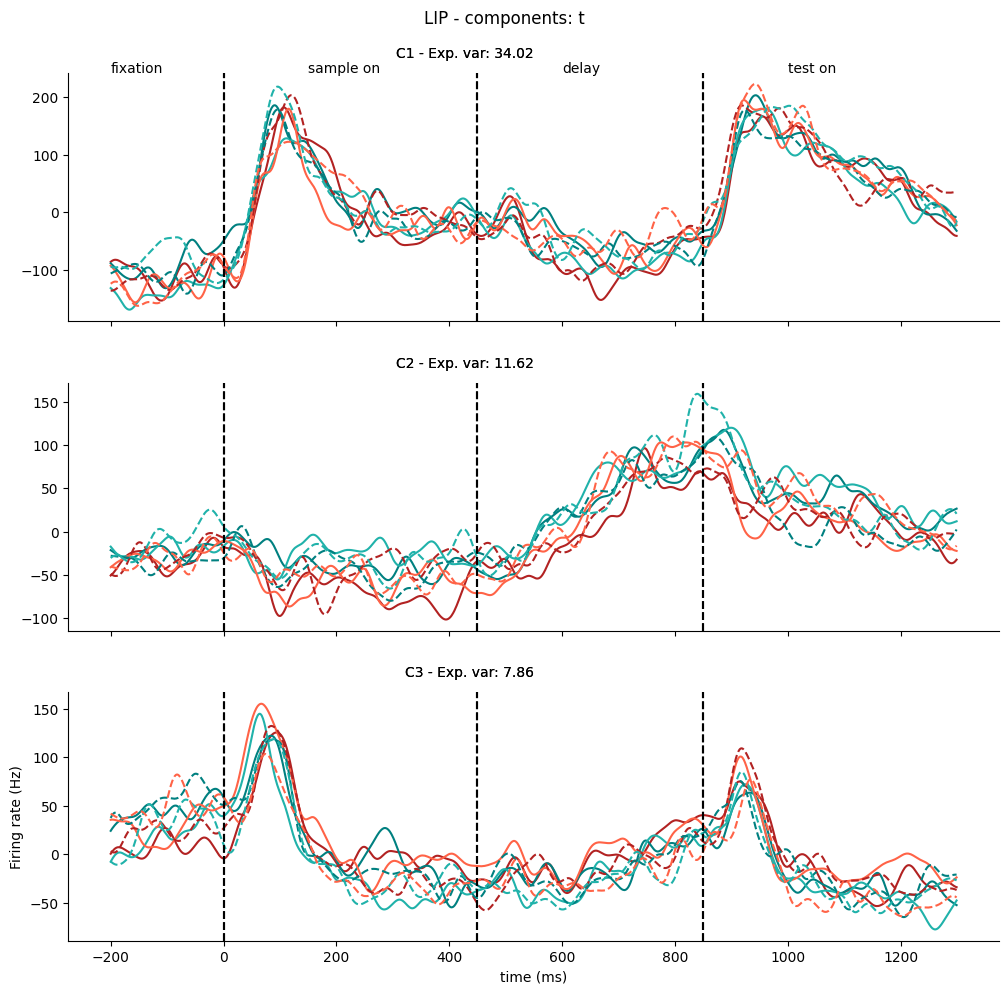

In [ ]:
save_fig=False
time = np.arange(T-400-450)-200
n_plots,i_plot=0,0#
for i in range(len(comp_in_z)):
    i_comp = comp_in_z[i]
    if i_plot!=0 and i_plot < comp_plot:
        ax=ax_all[i_plot]
        i_plot+=1
    else:    
        f,ax_all=plt.subplots(3,1,figsize=(10,10),sharex=True)
        ax=ax_all[0]
        i_plot =1
    for i_m in range(2):
        lstyle = '-' if i_m == 0 else '--'
        for s in samples.keys():
            ax.plot(time,Z[i_comp][i_plot-1][samples[s]][i_m],color=task_constants.PALETTE_B1[s],linestyle=lstyle)
        max_v = np.max(Z[i_comp][i_plot-1][samples[s]])
        min_v = np.min(Z[i_comp][i_plot-1][samples[s]])
        ax.axvline(0,color='k',linestyle='--')
        ax.axvline(450,color='k',linestyle='--')
        ax.axvline(850,color='k',linestyle='--')
        ax.text(0.5,1.05,'C%d - Exp. var: %.2f'%(i_plot,variances['component_var'][i_comp][i_plot-1]),horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes)
        ax.set_title(' ',fontsize=40)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
    if i_plot == 1:
        ax.text(-200, ax.get_ylim()[1], 'fixation')
        ax.text(150, ax.get_ylim()[1], 'sample on')
        ax.text(600, ax.get_ylim()[1], 'delay')
        ax.text(1000, ax.get_ylim()[1], 'test on')
    if i_plot == 3:
        ax.set(xlabel='time (ms)', ylabel='Firing rate (Hz)')
    f.suptitle('%s - components: %s'%(area.upper(),i_comp))
    f.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    if save_fig:
        path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' +i_comp+ '_components.jpg'
        f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)